# Análisis de Errores en Valores en SECOP

En el siguiente análsis se presenta una descripción de los errores encontrados

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
secop_i_ceros = pd.read_csv('Datasets/secop_i_6cerosfinal.csv')
secop_i_varias = pd.read_csv('Datasets/secop_i_otras_estrategias.csv')
secop_ii = pd.read_csv('Datasets/secop_ii_errores_valor.csv')

## SECOP I

In [3]:
# union de los datasets
secop_i = pd.concat([secop_i_ceros[["Error Cuantia proceso", "Tipo Error Cuantia Proceso", "Error Cuantia Contrato",\
                                    "Tipo Error Cuantia Contrato", "Error Adicion",\
                                    "Tipo Error Adicion"]],\
                    secop_i_varias[["Error Cuantia proceso", "Tipo Error Cuantia Proceso", "Error Cuantia Contrato",\
                                    "Tipo Error Cuantia Contrato", "Error Adicion",\
                                    "Tipo Error Adicion"]]])

El conjunto de datos se compone de una muestra de 1150 contratos

In [4]:
secop_i.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 0 to 599
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Error Cuantia proceso        1150 non-null   float64
 1   Tipo Error Cuantia Proceso   179 non-null    object 
 2   Error Cuantia Contrato       1150 non-null   float64
 3   Tipo Error Cuantia Contrato  475 non-null    object 
 4   Error Adicion                1149 non-null   float64
 5   Tipo Error Adicion           90 non-null     object 
dtypes: float64(3), object(3)
memory usage: 63.1+ KB


In [5]:
secop_i.head()

,Error Cuantia proceso,Tipo Error Cuantia Proceso,Error Cuantia Contrato,Tipo Error Cuantia Contrato,Error Adicion,Tipo Error Adicion
0,0.0,NaN,1.0,Agregación de ceros,0.0,NaN
1,0.0,NaN,1.0,Agregación de ceros,0.0,NaN
2,0.0,NaN,1.0,Agregación de ceros,0.0,NaN
3,0.0,NaN,0.0,NaN,0.0,NaN
4,0.0,NaN,1.0,Agregación de ceros,0.0,NaN


>¿Cuál es el número total de errores? ¿Cuál es la relación de los errores en cada uno de los campos?

Creación de la columna que registra los errores

In [6]:
condicion = [
    (secop_i["Error Cuantia proceso"].eq(1) &\
     secop_i["Error Cuantia Contrato"].eq(0) & secop_i["Error Adicion"].eq(0)),
    (secop_i["Error Cuantia proceso"].eq(1) &\
     secop_i["Error Cuantia Contrato"].eq(0) & secop_i["Error Adicion"].eq(1)),
    (secop_i["Error Cuantia proceso"].eq(1) &\
     secop_i["Error Cuantia Contrato"].eq(1) & secop_i["Error Adicion"].eq(1)),
    (secop_i["Error Cuantia proceso"].eq(0) &\
     secop_i["Error Cuantia Contrato"].eq(0) & secop_i["Error Adicion"].eq(1)),
    (secop_i["Error Cuantia proceso"].eq(0) &\
     secop_i["Error Cuantia Contrato"].eq(1) & secop_i["Error Adicion"].eq(1)),
    (secop_i["Error Cuantia proceso"].eq(0) &\
     secop_i["Error Cuantia Contrato"].eq(0) & secop_i["Error Adicion"].eq(0)),
    (secop_i["Error Cuantia proceso"].eq(0) &\
     secop_i["Error Cuantia Contrato"].eq(1) & secop_i["Error Adicion"].eq(0)),
    (secop_i["Error Cuantia proceso"].eq(1) &\
     secop_i["Error Cuantia Contrato"].eq(1) & secop_i["Error Adicion"].eq(0))
]

valores = ["proceso", "proceso & adición", "proceso & inicial & adición",\
           "adición", "inicial & adición", "ninguna", "inicial", "proceso & inicial"]

secop_i["Error"] = np.select(condicion, valores)

Número total de errores

In [7]:
len(secop_i[secop_i.Error != "ninguna"])

654

Por lo tanto, la efectividad de las consulta son

In [8]:
len(secop_i[secop_i.Error != "ninguna"])/len(secop_i)*100

56.72159583694709

Relación de errores para cada uno de los campos

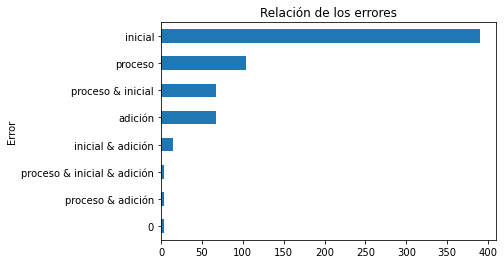

In [9]:
secop_i[secop_i.Error != "ninguna"].groupby('Error')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Relación de los errores')

> ¿Tipo de error en el valor del proceso?

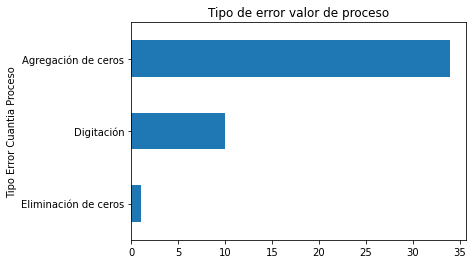

In [10]:
secop_i_ceros[secop_i_ceros['Error Cuantia proceso'] == 1].groupby('Tipo Error Cuantia Proceso')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Tipo de error valor de proceso')

> ¿Tipo de error en el valor del contrato?

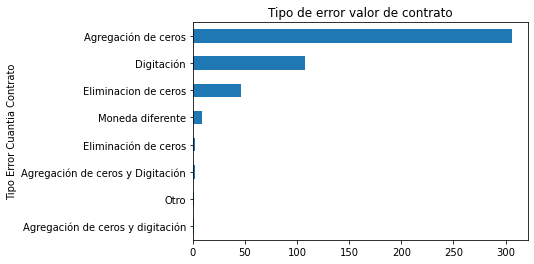

In [11]:
secop_i[secop_i['Error Cuantia Contrato'] == 1].groupby('Tipo Error Cuantia Contrato')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Tipo de error valor de contrato')

> ¿Tipo de error en las adiciones?

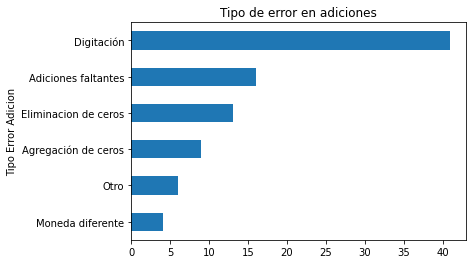

In [12]:
secop_i[secop_i['Error Adicion'] == 1].groupby('Tipo Error Adicion')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Tipo de error en adiciones')

## SECOP II

In [13]:
secop_ii.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Index pandas                       245 non-null    int64  
 1   ID Contrato                        245 non-null    object 
 2   Nombre Entidad                     245 non-null    object 
 3   Departamento                       245 non-null    object 
 4   Ciudad                             245 non-null    object 
 5   Orden                              245 non-null    object 
 6   Proceso de Compra                  245 non-null    object 
 7   Tipo de Contrato                   245 non-null    object 
 8   Modalidad de Contratacion          245 non-null    object 
 9   Descripcion del Proceso            245 non-null    object 
 10  Valor del Contrato                 245 non-null    object 
 11  URLProceso                         245 non-null    object 

In [14]:
secop_ii.head()

,Index pandas,ID Contrato,Nombre Entidad,Departamento,Ciudad,Orden,Proceso de Compra,Tipo de Contrato,Modalidad de Contratacion,Descripcion del Proceso,...,tipo-consulta,Asignación,Error Valor estimado,Tipo de error Valor estimado,Error Valor del contrato,Tipo de error Valor del contrato,Valor real del valor del contrato,Error adiciones,Tipo de error adiciones,Observaciones
0,49726,CO1.PCCNTR.878014,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,Distrito Capital de Bogotá,No Definido,Territorial,CO1.BDOS.777545,Prestación de servicios,Contratación régimen especial,prestar servicos profesionales a la gestión ad...,...,Adiciones alto ratio min max,Nicolas,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
1,85602,CO1.PCCNTR.876383,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,Distrito Capital de Bogotá,No Definido,Territorial,CO1.BDOS.778122,Prestación de servicios,Contratación régimen especial,prestar servicos profesionales a la gestión ad...,...,Adiciones alto ratio min max,Nicolas,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,2707,CO1.PCCNTR.880613,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,Distrito Capital de Bogotá,No Definido,Territorial,CO1.BDOS.778217,Prestación de servicios,Contratación régimen especial,prestar servicos profesionales a la gestión ad...,...,Adiciones alto ratio min max,Nicolas,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,92479,CO1.PCCNTR.875127,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,Distrito Capital de Bogotá,No Definido,Territorial,CO1.BDOS.777552,Prestación de servicios,Contratación régimen especial,prestar servicos profesionales a la gestión ad...,...,Adiciones alto ratio min max,Nicolas,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,12708,CO1.PCCNTR.877605,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,Distrito Capital de Bogotá,No Definido,Territorial,CO1.BDOS.777552,Prestación de servicios,Contratación régimen especial,prestar servicos profesionales a la gestión ad...,...,Adiciones alto ratio min max,Nicolas,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN


>¿Cuál es el número total de errores? ¿Cuál es la relación de los errores en cada uno de los campos?

Creación de la columna que registra los errores

In [15]:
condicion = [
    (secop_ii["Error Valor estimado"].eq(1) &\
     secop_ii["Error Valor del contrato"].eq(0) & secop_ii["Error adiciones"].eq(0)),
    (secop_ii["Error Valor estimado"].eq(1) &\
     secop_ii["Error Valor del contrato"].eq(0) & secop_ii["Error adiciones"].eq(1)),
    (secop_ii["Error Valor estimado"].eq(1) &\
     secop_ii["Error Valor del contrato"].eq(1) & secop_ii["Error adiciones"].eq(1)),
    (secop_ii["Error Valor estimado"].eq(0) &\
     secop_ii["Error Valor del contrato"].eq(0) & secop_ii["Error adiciones"].eq(1)),
    (secop_ii["Error Valor estimado"].eq(0) &\
     secop_ii["Error Valor del contrato"].eq(1) & secop_ii["Error adiciones"].eq(1)),
    (secop_ii["Error Valor estimado"].eq(0) &\
     secop_ii["Error Valor del contrato"].eq(0) & secop_ii["Error adiciones"].eq(0)),
    (secop_ii["Error Valor estimado"].eq(0) &\
     secop_ii["Error Valor del contrato"].eq(1) & secop_ii["Error adiciones"].eq(0)),
    (secop_ii["Error Valor estimado"].eq(1) &\
     secop_ii["Error Valor del contrato"].eq(1) & secop_ii["Error adiciones"].eq(0))
]

valores = ["estimado", "estimado & adición", "estimado & inicial & adición",\
           "adición", "inicial & adición", "ninguna", "inicial", "estimado & inicial"]

secop_ii["Error"] = np.select(condicion, valores)

Número total de errores

In [16]:
len(secop_ii[secop_ii.Error != "ninguna"])

90

Por lo tanto, la efectividad de las consulta es

In [17]:
len(secop_ii[secop_ii.Error != "ninguna"])/len(secop_ii)*100

36.734693877551024

Relación de errores para cada uno de los campos

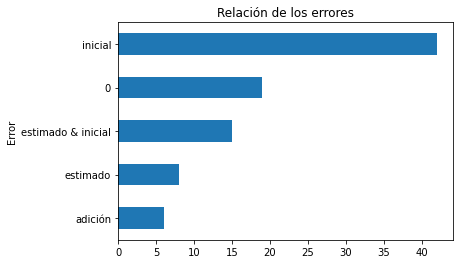

In [18]:
secop_ii[secop_ii.Error != "ninguna"].groupby('Error')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Relación de los errores')

> ¿Tipo de error en el valor del proceso?

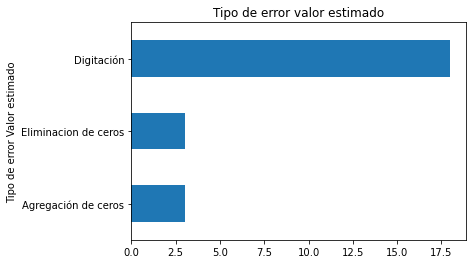

In [19]:
secop_ii[secop_ii['Error Valor estimado'] == 1].groupby('Tipo de error Valor estimado')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Tipo de error valor estimado')

> ¿Tipo de error en el valor del contrato?

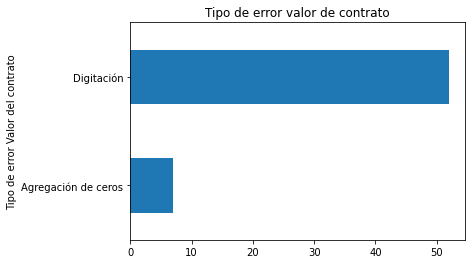

In [20]:
secop_ii[secop_ii['Error Valor del contrato'] == 1].groupby('Tipo de error Valor del contrato')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Tipo de error valor de contrato')

> ¿Tipo de error en las adiciones?

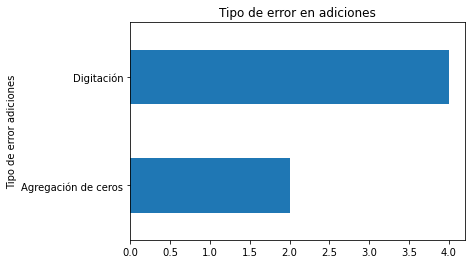

In [21]:
secop_ii[secop_ii['Error adiciones'] == 1].groupby('Tipo de error adiciones')\
    .size()\
    .sort_values()\
    .plot(kind='barh', title='Tipo de error en adiciones')